# Projet 10 : Réalisez une application de recommandation de contenu

## Contexte

Vous êtes le CTO et cofondateur de la start-up My Content qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. Vous êtes en pleine construction d’un premier MVP (Minimum Viable Product) qui prendra la forme d’une application.

Dans un premier temps, votre start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers en utilisant des données disponibles en ligne puisque vous n'en avez pas encore.

Votre mission est de développer une première version de votre système de recommandation d'une sélection de cinq articles, sous forme d’Azure Functions, tout en prenant en compte l'ajout de nouveaux articles et utilisateurs.

Puis de réaliser une application simple de gestion du système de recommandation (interface d’affichage d’une liste d’id utilisateurs, d’appel Azure functions pour l’id choisi, et d’affichage des 5 articles recommandés)

## Contenu des données du jeu de données News Portal User Interactions by Globo.com :

Le jeu de données provient du portail d’actualité brésilien Globo. Il traite des clics utilisateurs/articles.

Il contient 3 fichiers et un dossier zip :
- clicks.zip : contient les données d’interaction utilisateur → article (clics, horodatage, etc.).

- clicks_sample.csv : contient un échantillon des données d’interaction utilisateur → article (clics, horodatage, etc.).

- articles_metadata.csv : les métadonnées des articles (titre, catégorie, etc.).

- articles_embeddings.pickle : embeddings pré-calculés des articles.


## Librairies utilisées avec le langage Python :

In [1]:
!pip install openTSNE

In [2]:
# Importation des librairies
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from openTSNE import TSNE
from sklearn import manifold
import pickle
import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Données brutes :

### articles_metadata.csv

In [4]:
# Importation des données :
# data_articles = pd.read_csv('C:/tutorial-env/OCR/Projet10/data/articles_metadata.csv',encoding='latin',delimiter=",")
data_articles = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P10/articles_metadata.csv',encoding='latin',delimiter=",")
data_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [3]:
data_articles.shape

(364047, 5)

In [4]:
data_articles.dtypes

article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

In [5]:
data_articles.duplicated().sum()

0

In [6]:
data_articles[['article_id','category_id','publisher_id']] = data_articles[['article_id','category_id','publisher_id']].astype(str)
data_articles[['article_id','category_id','publisher_id']].describe()

,article_id,category_id,publisher_id
count,364047,364047,364047
unique,364047,461,1
top,0,281,0
freq,1,12817,364047


Modifions le type des colonnes pour en savoir plus et pour pouvoir interpréter les dates de la colonne "created_at_ts"

In [7]:
data_articles['words_count'] = data_articles[['words_count']].astype(int)
data_articles['article_created_at'] = pd.to_datetime(data_articles['created_at_ts'], unit='ms')
data_articles.describe()

,created_at_ts,words_count,article_created_at
count,3.640470e+05,364047.000000,364047
mean,1.474070e+12,190.897727,2016-09-16 23:57:17.328421888
min,1.159356e+12,0.000000,2006-09-27 11:14:35
25%,1.444925e+12,159.000000,2015-10-15 16:00:43.500000
50%,1.489422e+12,186.000000,2017-03-13 16:27:29
75%,1.509891e+12,218.000000,2017-11-05 14:09:11
max,1.520943e+12,6690.000000,2018-03-13 12:12:30
std,4.293038e+10,59.502766,NaN


Le csv articles_metadata comprend 364047 articles avec des id uniques, sans doublons et sans valeurs manquantes.

Les articles appartiennent à l'une des 461 catégories.

La colonne "publisher_id" n'a qu'un seul id, elle n'est donc pas pertinente pour notre projet.

La nouvelle colonne "created_at" correspond à la date et heure de publication de l'article.

Le nombre moyen de mots par articles est de 190 mots avec un minimum de 0 et un maximum de 6690.


### clicks.csv

In [8]:
# Importation des données :
# Chercher tous les fichiers .csv du dossier
all_files = glob.glob(os.path.join("C:/tutorial-env/OCR/Projet10/data/clicks/", "*.csv"))
# all_files = glob.glob(os.path.join("D:/tutorial-env/OCR/Projet10/clicks/", "*.csv"))

# Charger et concaténer tous les fichiers
dfs = []
for f in all_files:
    chunksize = 100_000 # Pour lire par lot afin de réduire la mémoire
    df = pd.read_csv(f,encoding='latin',delimiter=",", chunksize=chunksize)
    for chunk in df:
        dfs.append(chunk)

clicks = pd.concat(dfs, ignore_index=True)
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [9]:
clicks.shape

(2988181, 12)

In [10]:
clicks.dtypes

user_id                object
session_id             object
session_start          object
session_size           object
click_article_id       object
click_timestamp        object
click_environment      object
click_deviceGroup      object
click_os               object
click_country          object
click_region           object
click_referrer_type    object
dtype: object

In [11]:
clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']] = clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']].astype(str)
clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']].describe()

,user_id,session_id,click_article_id,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,46033,3,5,8,11,28,7
top,5890,1507563657895091,160974,4,1,17,1,25,2
freq,1232,124,37213,2904478,1823162,1738138,2852406,804985,1602601


In [12]:
clicks.duplicated().sum()

0

Modifions le type des colonnes pour en savoir plus et pour pouvoir interpréter les dates des colonnes "session_start" et "click_timestamp".

In [13]:
clicks['session_size'] = clicks[['session_size']].astype(int)
clicks['session_start'] = pd.to_datetime(clicks['session_start'], unit='ms')
clicks['click_timestamp'] = pd.to_datetime(clicks['click_timestamp'], unit='ms')
clicks.describe()

,session_start,session_size,click_timestamp
count,2988181,2.988181e+06,2988181
mean,2017-10-08 14:17:08.013157120,3.901885e+00,2017-10-08 14:51:05.606100224
min,2017-10-01 02:37:03,2.000000e+00,2017-10-01 03:00:00.026000
25%,2017-10-04 13:35:52,2.000000e+00,2017-10-04 14:20:52.854000128
50%,2017-10-08 20:09:00,3.000000e+00,2017-10-08 20:35:30.480999936
75%,2017-10-11 19:16:54,4.000000e+00,2017-10-11 19:43:24.600999936
max,2017-10-17 03:36:19,1.240000e+02,2017-11-13 20:04:14.886000
std,NaN,3.929941e+00,NaN


La fusion des différents csv clicks_hour comprend 2988181 lignes et 12 colonnes, sans doublons et sans valeurs manquantes.

Les données sont basées sur les 1048594 sessions de 322897 clients. Ils ont cliqués sur 46033 articles différents.

Les colonnes 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type' permettent de comprendre le contexte de l'utilisateur. Nous ne les utiliserons pas dans notre projet.

La colonne "session_start" correspond à la date et heure d'ouverture de la session.

La colonne "click_timestamp" correspond à la date et heure du clic.

Le nombre moyen de clics par session, portés par la colonne "session_size",  est de 3.9 clicls avec un minimum de 2 et un maximum de 124.

Créons notre dataframe final avec les variables qui nous intéressent :

In [14]:
# Renommer des colonnes pour la jointure
clicks = clicks.rename(columns={'click_article_id': 'article_id'})
data_articles = data_articles.rename(columns={'category_id': 'article_category_id'})
data_articles = data_articles.rename(columns={'words_count': 'article_words_count'})

In [15]:
# Ajout des colonnes à clicks
df = clicks.merge(data_articles[['article_id', 'article_category_id', 'article_words_count' ,	'article_created_at']],
    on='article_id', how='left')
df.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2,247,239,2017-09-30 15:11:56


In [16]:
# Suppression de colonnes non  pertinentes
df = df.drop(['click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'], axis=1)
df.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,247,239,2017-09-30 15:11:56


In [17]:
df.describe(include='all')

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
count,2988181,2988181,2988181,2.988181e+06,2988181,2988181,2988181,2.988181e+06,2988181
unique,322897,1048594,NaN,NaN,46033,NaN,316,NaN,NaN
top,5890,1507563657895091,NaN,NaN,160974,NaN,281,NaN,NaN
freq,1232,124,NaN,NaN,37213,NaN,370843,NaN,NaN
mean,NaN,NaN,2017-10-08 14:17:08.013157120,3.901885e+00,NaN,2017-10-08 14:51:05.606100224,NaN,2.086283e+02,2017-09-30 05:50:23.356218368
min,NaN,NaN,2017-10-01 02:37:03,2.000000e+00,NaN,2017-10-01 03:00:00.026000,NaN,0.000000e+00,2006-12-20 00:00:00
25%,NaN,NaN,2017-10-04 13:35:52,2.000000e+00,NaN,2017-10-04 14:20:52.854000128,NaN,1.730000e+02,2017-10-03 17:56:13
50%,NaN,NaN,2017-10-08 20:09:00,3.000000e+00,NaN,2017-10-08 20:35:30.480999936,NaN,1.980000e+02,2017-10-07 19:10:41
75%,NaN,NaN,2017-10-11 19:16:54,4.000000e+00,NaN,2017-10-11 19:43:24.600999936,NaN,2.320000e+02,2017-10-11 10:10:51
max,NaN,NaN,2017-10-17 03:36:19,1.240000e+02,NaN,2017-11-13 20:04:14.886000,NaN,6.690000e+03,2017-11-14 13:26:54


Il paraît étrange que les dates des sessions soient comprises entre le 01/10/2017 et le 17/10/2017 alors que certains clics ont une date jusqu'au 13/11/2017.

On peut considérer que les sessions ont une validité maximum de 24h et donc enlever les sessions qui ont des clics plus de 24h après le début de la session.

In [18]:
# Récupérer les lignes des clics invalides
invalid_click = df[(df['click_timestamp'] > df['session_start'] + pd.Timedelta(hours=24)) | (df['article_created_at'] > df['click_timestamp'])]
print(f"Nb de clics invalides (plus de 24h après le début de la session) : {len(invalid_click)}")

Nb de clics invalides (plus de 24h après le début de la session) : 10620


In [19]:
# Récupérer les session_id uniques des clics invalides
invalid_sessions = invalid_click['session_id'].unique()
print(f"Nombre de sessions invalides : {len(invalid_sessions)}")
print(invalid_sessions)

Nombre de sessions invalides : 4841
['1506826396181805' '1506826825256897' '1506827671281111' ...
 '1508209734334947' '1508209945362001' '1508211376302329']


In [20]:
# Supprimer du DataFrame principal toutes les lignes de ces sessions invalides
dfinal = df[~df['session_id'].isin(invalid_sessions)].copy()
dfinal

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,247,239,2017-09-30 15:11:56
...,...,...,...,...,...,...,...,...,...
2988174,34979,1508211369104327,2017-10-17 03:36:09,7,157478,2017-10-17 03:46:14.116,281,259,2017-10-16 04:01:02
2988175,10051,1508211372158328,2017-10-17 03:36:12,2,211442,2017-10-17 03:38:47.302,340,240,2017-10-16 21:02:00
2988176,10051,1508211372158328,2017-10-17 03:36:12,2,84911,2017-10-17 03:39:17.302,174,171,2017-10-16 21:00:19
2988179,123718,1508211379189330,2017-10-17 03:36:19,2,234481,2017-10-17 03:38:33.583,375,212,2017-10-16 19:19:32


De même, on peut considérer que les lignes consultant des articles à 0 mots ne sont également pas pertinentes pour comprendre les goûts des utilisateurs.

In [21]:
article_empty = dfinal[dfinal['article_words_count'] == 0]
print(f"Nombre de lignes avec articles vides : {len(article_empty)}")
article_empty

Nombre de lignes avec articles vides : 62


,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
40,16,1506825660149753,2017-10-01 02:41:00,7,206233,2017-10-01 12:31:57.687,331,0,2017-09-30 17:11:56
7151,2621,1506848948202381,2017-10-01 09:09:08,3,206233,2017-10-01 09:15:23.710,331,0,2017-09-30 17:11:56
9747,3559,1506852410644332,2017-10-01 10:06:50,2,206233,2017-10-01 10:12:17.434,331,0,2017-09-30 17:11:56
10034,3654,1506852643582428,2017-10-01 10:10:43,2,206233,2017-10-01 10:15:56.528,331,0,2017-09-30 17:11:56
13533,4925,1506855844127726,2017-10-01 11:04:04,5,206233,2017-10-01 11:17:36.425,331,0,2017-09-30 17:11:56
...,...,...,...,...,...,...,...,...,...
1165045,202366,1507299071590156,2017-10-06 14:11:11,22,233934,2017-10-06 15:25:17.517,375,0,2017-10-05 13:44:16
1169593,15747,1507300634378688,2017-10-06 14:37:14,5,233934,2017-10-06 14:55:55.023,375,0,2017-10-05 13:44:16
1180464,159029,1507304161117344,2017-10-06 15:36:01,2,233934,2017-10-06 15:36:04.432,375,0,2017-10-05 13:44:16
1447217,93200,1507461447272644,2017-10-08 11:17:27,4,315395,2017-10-08 12:11:45.854,431,0,2015-02-05 11:34:59


In [22]:
dfinal = dfinal.drop(dfinal[dfinal['article_words_count'] == 0].index)
dfinal

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,247,239,2017-09-30 15:11:56
...,...,...,...,...,...,...,...,...,...
2988174,34979,1508211369104327,2017-10-17 03:36:09,7,157478,2017-10-17 03:46:14.116,281,259,2017-10-16 04:01:02
2988175,10051,1508211372158328,2017-10-17 03:36:12,2,211442,2017-10-17 03:38:47.302,340,240,2017-10-16 21:02:00
2988176,10051,1508211372158328,2017-10-17 03:36:12,2,84911,2017-10-17 03:39:17.302,174,171,2017-10-16 21:00:19
2988179,123718,1508211379189330,2017-10-17 03:36:19,2,234481,2017-10-17 03:38:33.583,375,212,2017-10-16 19:19:32


In [23]:
dfinal.describe(include='all')

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
count,2965757,2965757,2965757,2.965757e+06,2965757,2965757,2965757,2.965757e+06,2965757
unique,322226,1043753,NaN,NaN,45350,NaN,315,NaN,NaN
top,5890,1507309773225261,NaN,NaN,160974,NaN,281,NaN,NaN
freq,1232,98,NaN,NaN,36931,NaN,368142,NaN,NaN
mean,NaN,NaN,2017-10-08 14:18:33.701989888,3.835269e+00,NaN,2017-10-08 14:41:46.105061888,NaN,2.086512e+02,2017-09-30 05:44:16.616829952
min,NaN,NaN,2017-10-01 02:37:03,2.000000e+00,NaN,2017-10-01 03:00:00.026000,NaN,5.000000e+00,2006-12-20 00:00:00
25%,NaN,NaN,2017-10-04 13:37:16,2.000000e+00,NaN,2017-10-04 14:15:46.656000,NaN,1.730000e+02,2017-10-03 17:41:21
50%,NaN,NaN,2017-10-08 20:10:12,3.000000e+00,NaN,2017-10-08 20:24:42.452999936,NaN,1.980000e+02,2017-10-07 18:17:39
75%,NaN,NaN,2017-10-11 19:18:37,4.000000e+00,NaN,2017-10-11 19:41:13.320999936,NaN,2.320000e+02,2017-10-11 09:52:04
max,NaN,NaN,2017-10-17 03:36:19,9.800000e+01,NaN,2017-10-18 00:59:45.692000,NaN,6.690000e+03,2017-10-17 19:00:41


Notre dataframe final contient 2976685 lignes de clics, de 322627 utilisateurs et de leurs 1047009 sessions.

Le nombre moyen de clics par session, portés par la colonne "session_size",  est de 3.9 clicls avec un minimum de 2 et un maximum de 124.

Les utilisateurs ont cliqués sur 45547 articles différents appartenant à 315 catégories différentes.

Le nombre moyen de mots des articles consultés est d'environ 209 mots avec un minimum de 0 et un maximum de 6690.

## Analyse exploratoire univariée :

Les variables catégorielles sont des identifiants qui ont trop de valeurs pour qu'elles soient pertinentes à analyser.

### Session_start

<Axes: title={'center': 'Volume de sessions par jour'}, xlabel='session_start'>

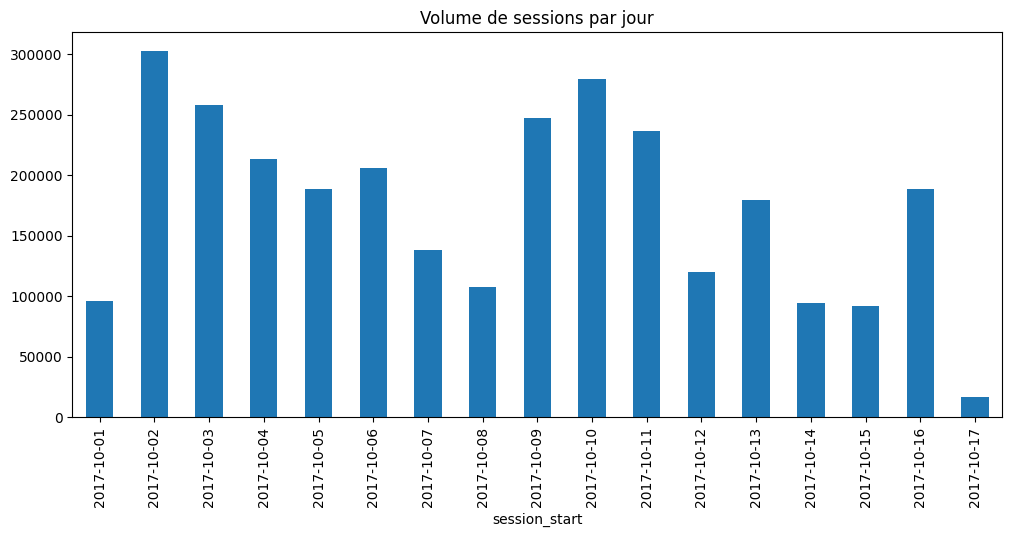

In [24]:
session_per_day = dfinal['session_start'].dt.date.value_counts().sort_index()
session_per_day.plot(figsize=(12,5),kind='bar', title="Volume de sessions par jour")

<Axes: title={'center': 'Sessions par jour de la semaine'}, xlabel='session_start'>

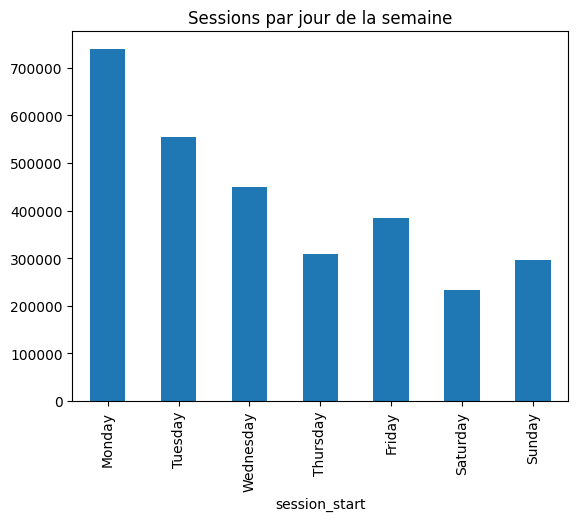

In [25]:
session_per_number_day = dfinal['session_start'].dt.day_name()
session_per_number_day.value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).plot(kind='bar', title="Sessions par jour de la semaine")

<Axes: title={'center': 'Sessions par heure du jour'}, xlabel='session_start'>

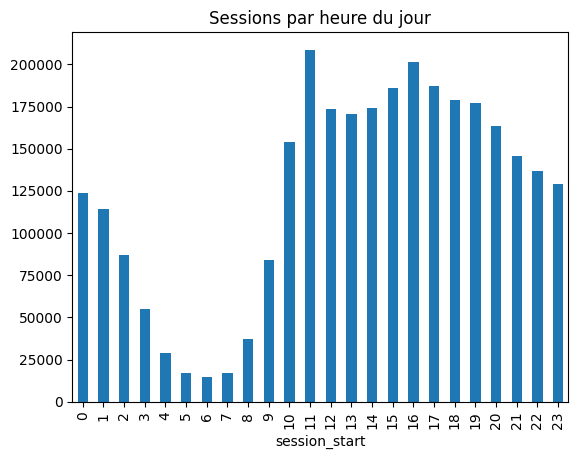

In [26]:
session_per_hour = dfinal['session_start'].dt.hour
dfinal['session_start'].dt.hour.value_counts().sort_index().plot(kind='bar', title="Sessions par heure du jour")

Nous avons les sessions des 17 premiers jours du mois d'octobre 2017. Le nombre de sessions par jour est plutôt fluctuant mais on peut voir qu'il y a moins de sessions ouvertes le week-end.

Il y a également moins d'ouverture de sessions entre 2 heures et 10 heures.

### Click_timestamp

<Axes: title={'center': 'Volume de clics par jour'}, xlabel='click_timestamp'>

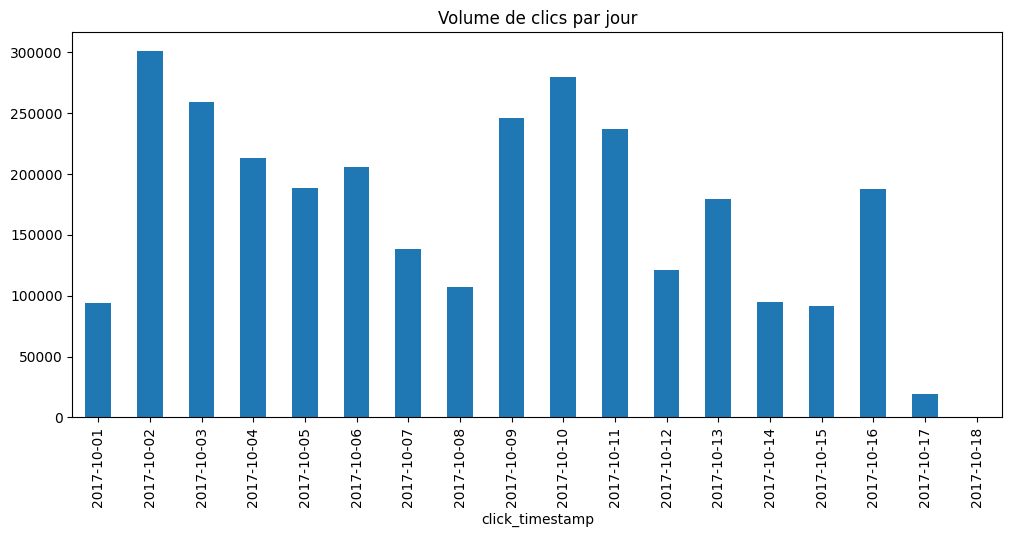

In [27]:
clic_per_day = dfinal['click_timestamp'].dt.date.value_counts().sort_index()
clic_per_day.plot(figsize=(12,5),kind='bar', title="Volume de clics par jour")

<Axes: title={'center': 'Clics par jour de la semaine'}, xlabel='click_timestamp'>

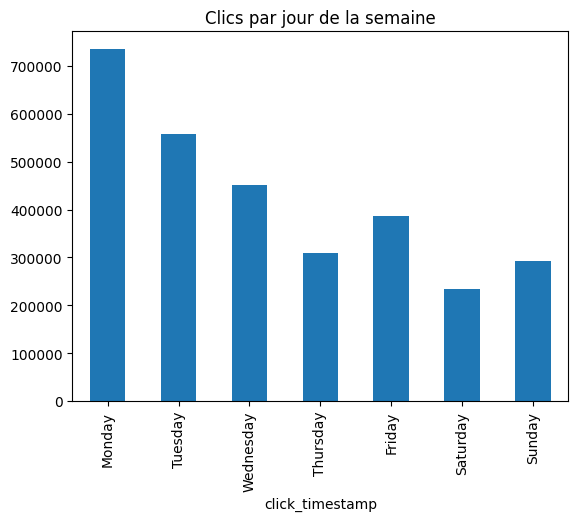

In [28]:
clic_per_number_day = dfinal['click_timestamp'].dt.day_name()
clic_per_number_day.value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).plot(kind='bar', title="Clics par jour de la semaine")

<Axes: title={'center': 'Clics par heure du jour'}, xlabel='click_timestamp'>

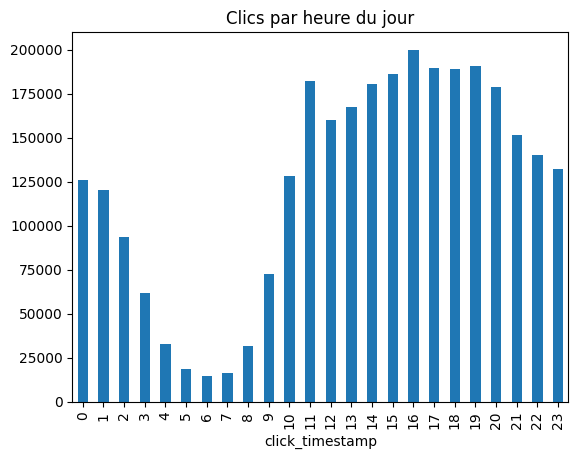

In [29]:
clic_per_hour = dfinal['click_timestamp'].dt.hour
dfinal['click_timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar', title="Clics par heure du jour")

On a les mêmes distributions pour les clics que pour les sessions ce qui est logique.

### Article_created_at

In [30]:
df_creation_article = pd.DataFrame()
df_creation_article['jour'] = dfinal['article_created_at'].dt.day.astype(str)
df_creation_article['mois'] = dfinal['article_created_at'].dt.month.astype(str)
df_creation_article['annee'] = dfinal['article_created_at'].dt.year.astype(str)
df_creation_article['mois_annee'] = df_creation_article['mois'].str.cat(df_creation_article['annee'] , sep='-')
df_creation_article

,jour,mois,annee,mois_annee
0,30,9,2017,9-2017
1,1,10,2017,10-2017
2,30,9,2017,9-2017
3,30,9,2017,9-2017
4,30,9,2017,9-2017
...,...,...,...,...
2988174,16,10,2017,10-2017
2988175,16,10,2017,10-2017
2988176,16,10,2017,10-2017
2988179,16,10,2017,10-2017


<Axes: title={'center': "Volume d'article créés par an"}, xlabel='annee'>

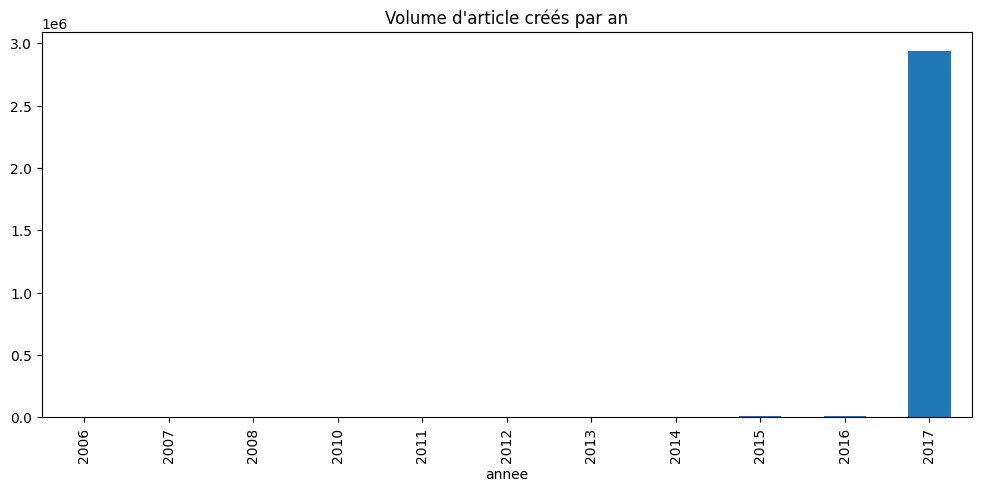

In [31]:
article_creation_per_year = df_creation_article['annee'].value_counts().sort_index()
article_creation_per_year.plot(figsize=(12,5),kind='bar', title="Volume d'article créés par an")

Quasiment la totalité des articles a été créé en 2017. Etudions plus cette année là :

<Axes: title={'center': "Volume d'articles créés par mois sur 2017"}, xlabel='mois_annee'>

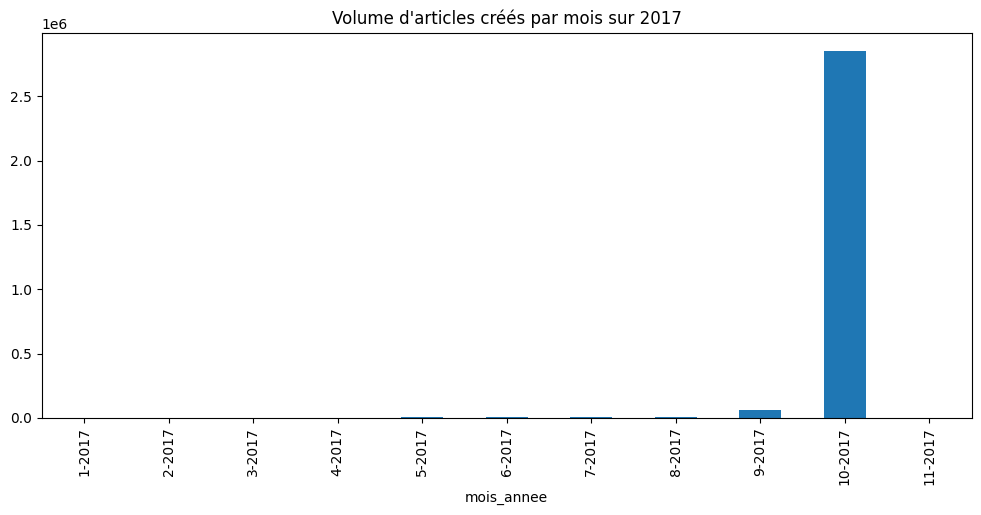

In [32]:
# Filtrer uniquement 2017
article_creation_2017 = df_creation_article[df_creation_article['annee'] == '2017']

# Ordre des mois
order = ['1-2017', '2-2017', '3-2017', '4-2017', '5-2017', '6-2017', '7-2017', '8-2017', '9-2017', '10-2017', '11-2017']

# Forcer l'ordre dans la colonne
article_creation_2017['mois_annee'] = pd.Categorical(
    article_creation_2017['mois_annee'],
    categories=order,
    ordered=True
)

# Compter les valeurs en respectant l'ordre défini
article_creation_2017_per_month = (
    article_creation_2017['mois_annee']
    .value_counts()
    .reindex(order) # respecte l'ordre défini
)

# Tracer
article_creation_2017_per_month.plot(
    figsize=(12,5),
    kind='bar',
    title="Volume d'articles créés par mois sur 2017"
)

Quasiment la totalité des articles a été créé au mois d'octobre 2017. Etudions plus ce mois là :

<Axes: title={'center': "Volume d'articles créés par jour sur le mois d'octobre 2017"}, xlabel='jour'>

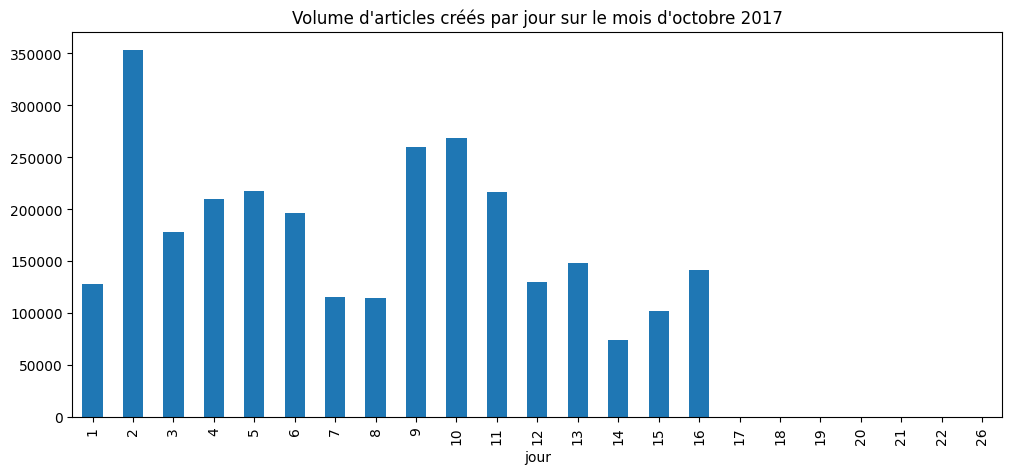

In [33]:
article_creation_oct_2017 = df_creation_article[df_creation_article['mois_annee'] == '10-2017']
# Ordre des mois
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '26']

# Forcer l'ordre dans la colonne
article_creation_oct_2017['jour'] = pd.Categorical(
    article_creation_oct_2017['jour'],
    categories=order,
    ordered=True
)

# Compter les valeurs en respectant l'ordre défini
article_creation_oct_2017_per_day = (
    article_creation_oct_2017['jour']
    .value_counts()
    .reindex(order) # respecte l'ordre défini
)

# Tracer
article_creation_oct_2017_per_day.plot(
    figsize=(12,5),
    kind='bar',
    title="Volume d'articles créés par jour sur le mois d'octobre 2017"
)

La création des articles s'est fait au fur et à mesure, donc chaque jour les utilisateurs peuvent accéder à de nouveaux articles.

Il y a un peu moins de création d'articles le week-end.

### Session_size

In [34]:
def describe_data_quant(data: pd.DataFrame,
                    col: str) :
    '''Génère des statistiques descriptives et leurs visualisation graphiques pour une colonne d'un dataframe
    Args:
        data (pd.DataFrame): Dataframe contenant les données à analyser
        col (str): Nom de la colonne que l'on veut analyser
    Sortie:
        Boxplot de la distribution de la colonne
        Histogramme de la distribution de la colonne
        pd.DataFrame: Affichage des statistiques descriptives sous forme d'un dataframe
    '''
    # Calcul des statistiques descriptives
    data_des = data.describe()

    # Création d'un dataframe avec les statistiques descriptives
    df = pd.DataFrame({
        'Caractéristiques': data_des[col].index,
        'Valeurs': data_des[col].values
    })

    sns.set_style("whitegrid")

    # Boxplot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(x=data[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

    # Histogramme
    plt.figure(figsize=(9, 8))
    sns.distplot(data[col], color='blue', kde=True)
    plt.title(f'Distribution de {col}')
    plt.ylabel("Fréquence de la donnée")
    plt.grid()
    plt.show()

    return df.style.set_caption(f'Caractéristiques de {col}')

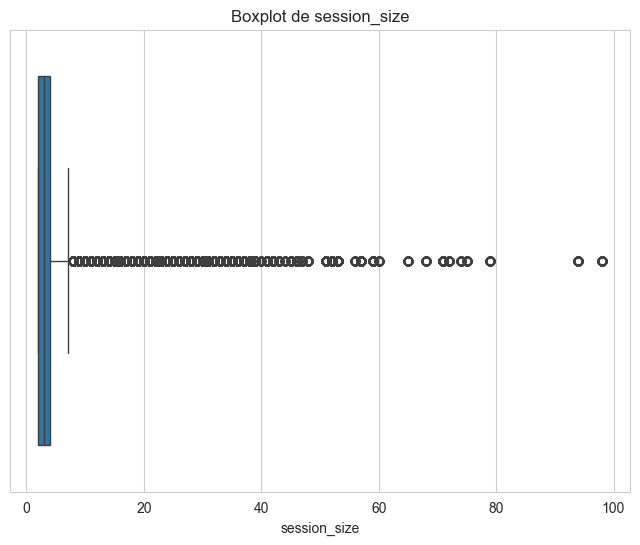

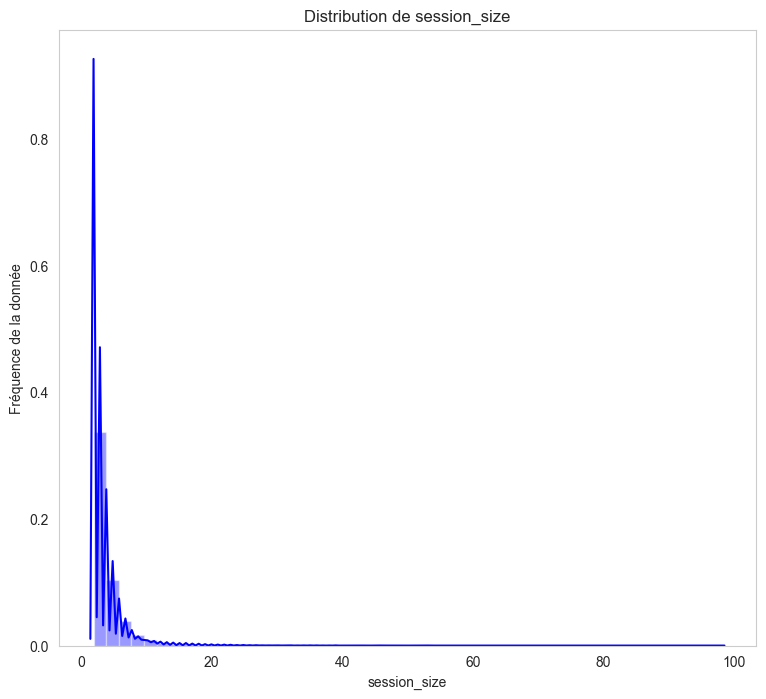

,Caractéristiques,Valeurs
0,count,2965757.000000
1,mean,3.835269
2,min,2.000000
3,25%,2.000000
4,50%,3.000000
5,75%,4.000000
6,max,98.000000
7,std,3.488608


In [35]:
describe_data_quant(dfinal, 'session_size')

On peut observer que les utilisateurs ont consulté au moins deux articles à chaque session. Dans la grande majorité des sessions, les utilisateurs ont consultés entre 2 et 4 articles.

### Article_words_count

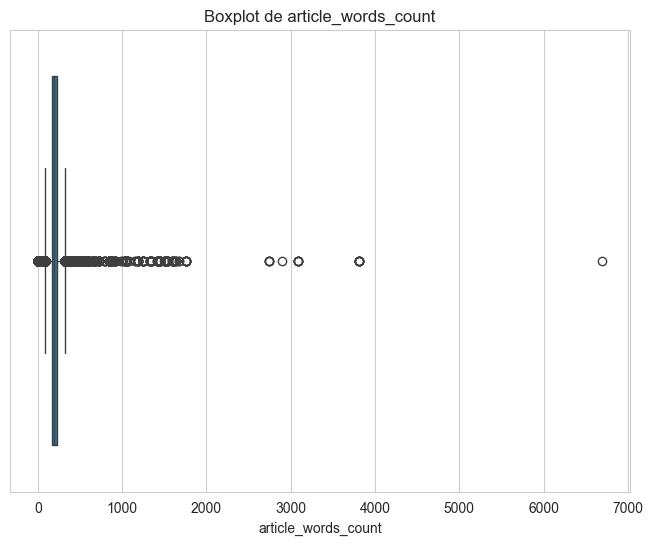

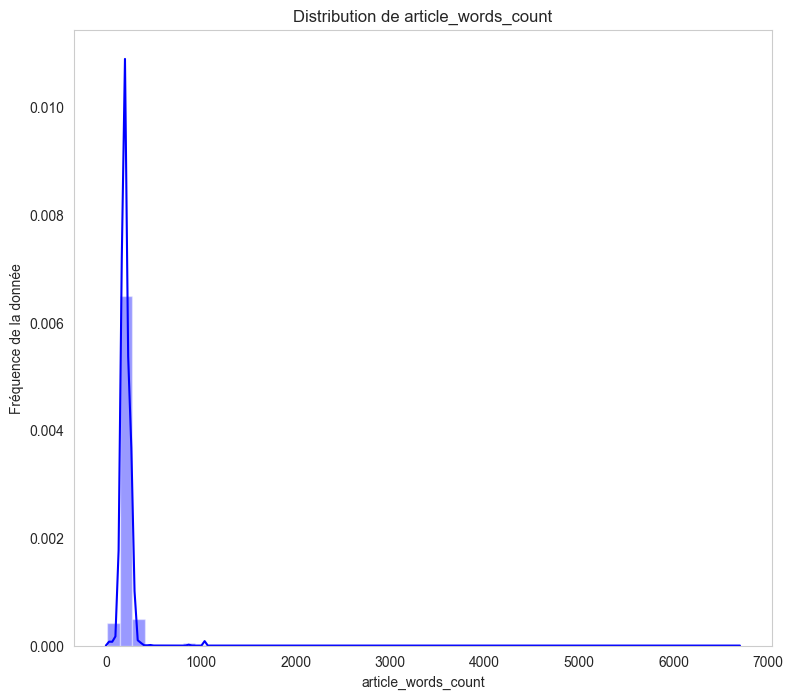

,Caractéristiques,Valeurs
0,count,2965757.000000
1,mean,208.651215
2,min,5.000000
3,25%,173.000000
4,50%,198.000000
5,75%,232.000000
6,max,6690.000000
7,std,81.690025


In [36]:
describe_data_quant(dfinal, 'article_words_count')

Les 3/4 des articles ont moins de 232 mots. En moyenne, les articles font environ 209 mots.

## Feature Engineering:

Créons les nouvelles colonnes "nb_session_per_user", "nb_article_per_user", "nb_category_article_per_user", "avg_wordcount_per_user", "nb_category_article_per_session" et "avg_wordcount_per_session".

In [37]:
# Colonne par utilisateur
user_features = dfinal.groupby('user_id').agg(
    nb_session_per_user=('session_id', 'nunique'),
    nb_article_per_user=('article_id', 'nunique'),
    nb_category_article_per_user=('article_category_id', 'nunique'),
    avg_wordcount_per_user=('article_words_count', 'mean')
).reset_index()
user_features

,user_id,nb_session_per_user,nb_article_per_user,nb_category_article_per_user,avg_wordcount_per_user
0,0,4,8,6,207.000000
1,1,6,12,9,212.083333
2,10,10,54,27,200.962963
3,100,4,10,7,194.200000
4,1000,2,8,7,205.375000
...,...,...,...,...,...
322221,99995,1,2,2,225.500000
322222,99996,3,9,6,194.444444
322223,99997,4,16,7,236.812500
322224,99998,6,14,9,241.500000


In [38]:
user_features.describe()

,nb_session_per_user,nb_article_per_user,nb_category_article_per_user,avg_wordcount_per_user
count,322226.000000,322226.000000,322226.000000,322226.000000
mean,3.239195,9.089257,5.809317,211.413255
std,3.796107,14.144149,6.006855,51.837985
min,1.000000,1.000000,1.000000,16.000000
25%,1.000000,2.000000,2.000000,190.200000
50%,2.000000,4.000000,4.000000,204.235294
75%,4.000000,10.000000,7.000000,220.500000
max,206.000000,1048.000000,101.000000,3434.500000


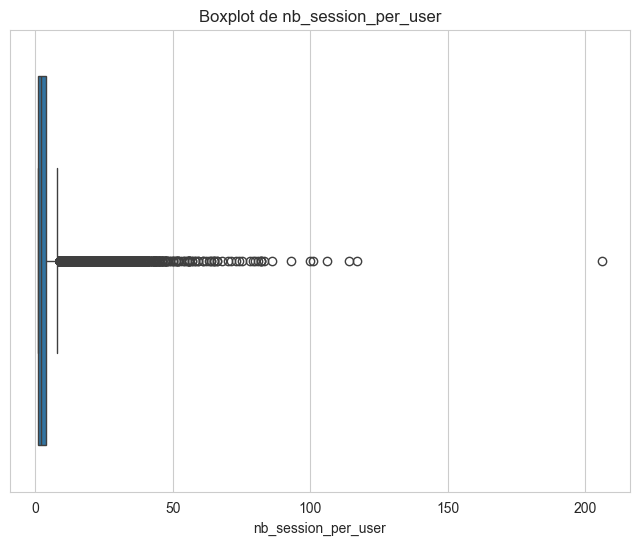

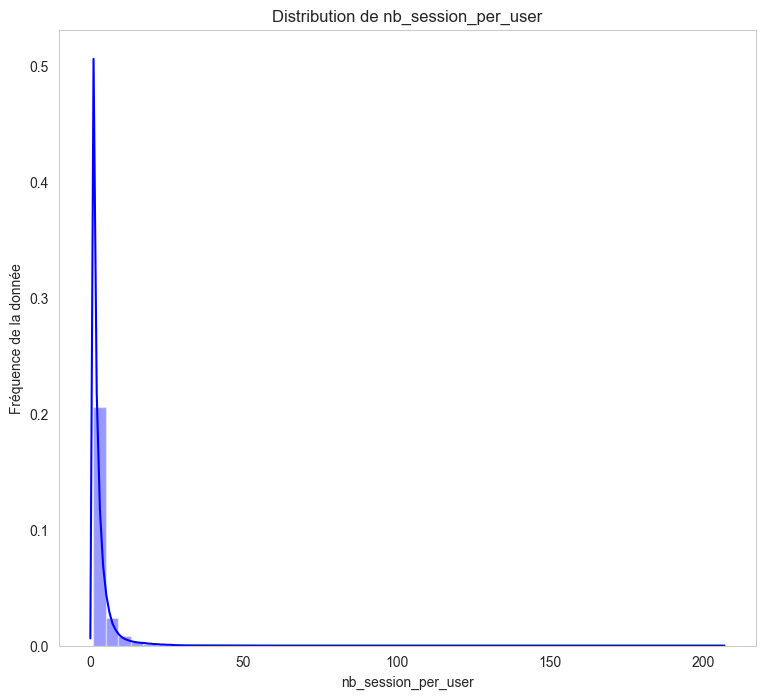

,Caractéristiques,Valeurs
0,count,322226.000000
1,mean,3.239195
2,std,3.796107
3,min,1.000000
4,25%,1.000000
5,50%,2.000000
6,75%,4.000000
7,max,206.000000


In [39]:
describe_data_quant(user_features, 'nb_session_per_user')

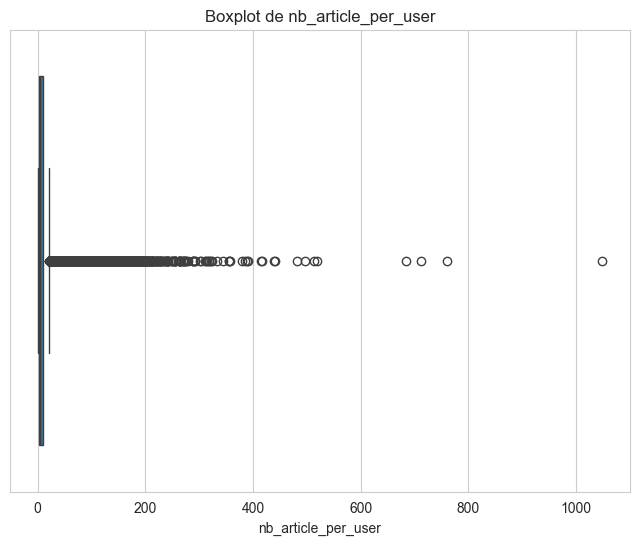

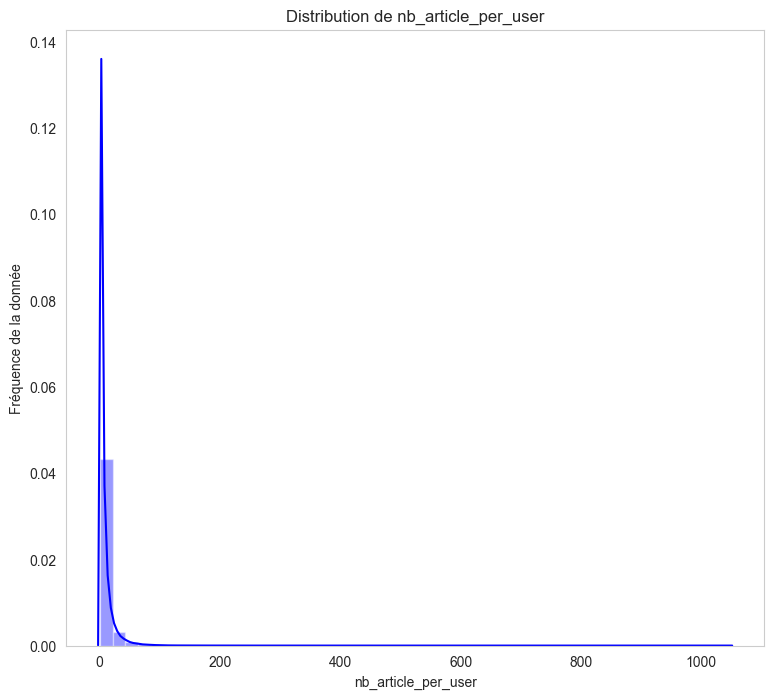

,Caractéristiques,Valeurs
0,count,322226.000000
1,mean,9.089257
2,std,14.144149
3,min,1.000000
4,25%,2.000000
5,50%,4.000000
6,75%,10.000000
7,max,1048.000000


In [40]:
describe_data_quant(user_features, 'nb_article_per_user')

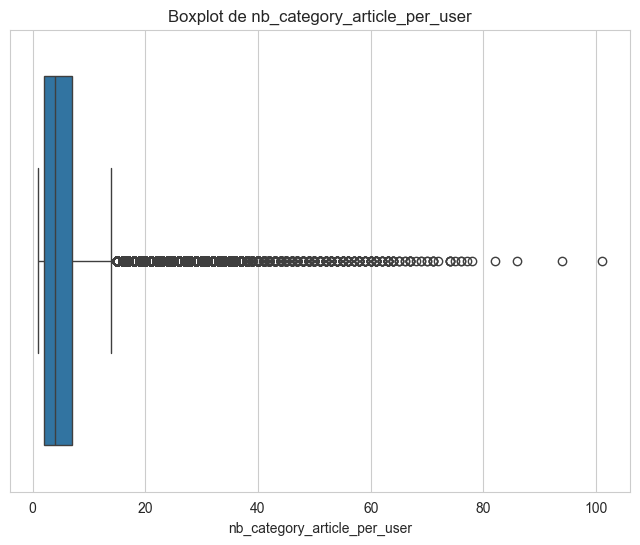

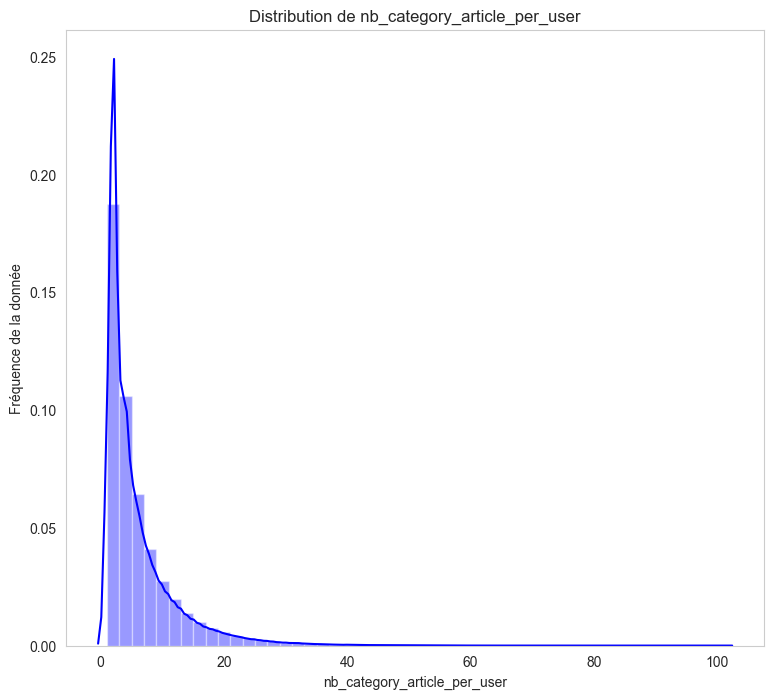

,Caractéristiques,Valeurs
0,count,322226.000000
1,mean,5.809317
2,std,6.006855
3,min,1.000000
4,25%,2.000000
5,50%,4.000000
6,75%,7.000000
7,max,101.000000


In [41]:
describe_data_quant(user_features, 'nb_category_article_per_user')

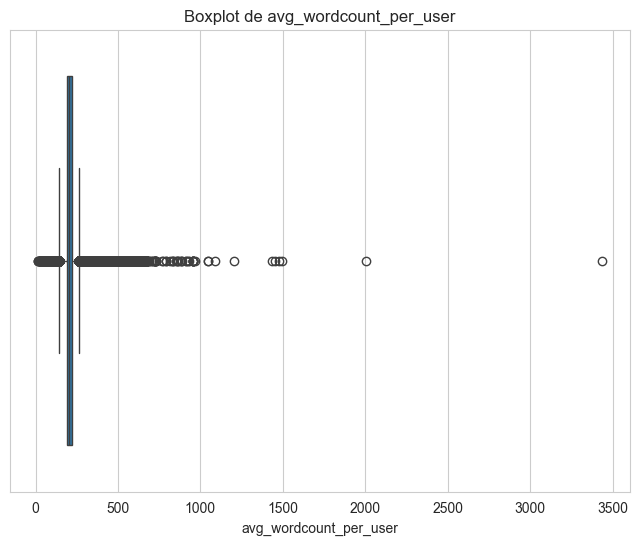

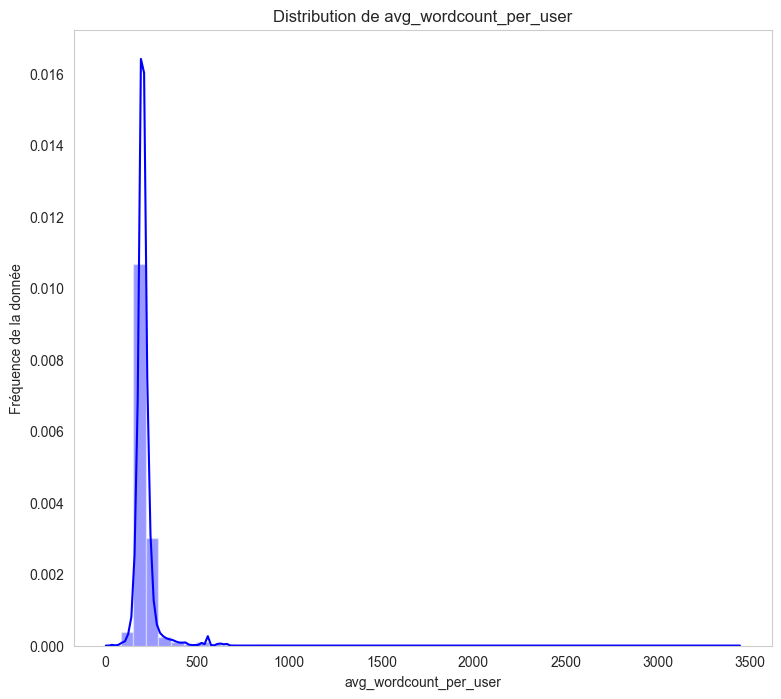

,Caractéristiques,Valeurs
0,count,322226.000000
1,mean,211.413255
2,std,51.837985
3,min,16.000000
4,25%,190.200000
5,50%,204.235294
6,75%,220.500000
7,max,3434.500000


In [42]:
describe_data_quant(user_features, 'avg_wordcount_per_user')

In [43]:
# Colonne par session
session_features = dfinal.groupby('session_id').agg(
    user_id=('user_id', 'first'),
    nb_article_per_session=('article_id', 'nunique'),
    nb_category_article_per_session=('article_category_id', 'nunique'),
    avg_wordcount_per_session=('article_words_count', 'mean')
).reset_index()
session_features

,session_id,user_id,nb_article_per_session,nb_category_article_per_session,avg_wordcount_per_session
0,1506825423271737,0,2,2,253.000000
1,1506825426267738,1,2,2,182.500000
2,1506825435299739,2,2,2,227.500000
3,1506825442704740,3,2,1,150.500000
4,1506825528135741,4,2,2,162.500000
...,...,...,...,...,...
1043748,1508211353112325,51746,4,4,178.750000
1043749,1508211367250326,289450,2,2,211.500000
1043750,1508211369104327,34979,7,6,212.285714
1043751,1508211372158328,10051,2,2,205.500000


In [44]:
session_features.describe()

,nb_article_per_session,nb_category_article_per_session,avg_wordcount_per_session
count,1.043753e+06,1.043753e+06,1.043753e+06
mean,2.841436e+00,2.438862e+00,2.100056e+02
std,1.680384e+00,1.279685e+00,5.710683e+01
min,1.000000e+00,1.000000e+00,1.600000e+01
25%,2.000000e+00,2.000000e+00,1.850000e+02
50%,2.000000e+00,2.000000e+00,2.030000e+02
75%,3.000000e+00,3.000000e+00,2.232500e+02
max,9.800000e+01,4.800000e+01,3.434500e+03


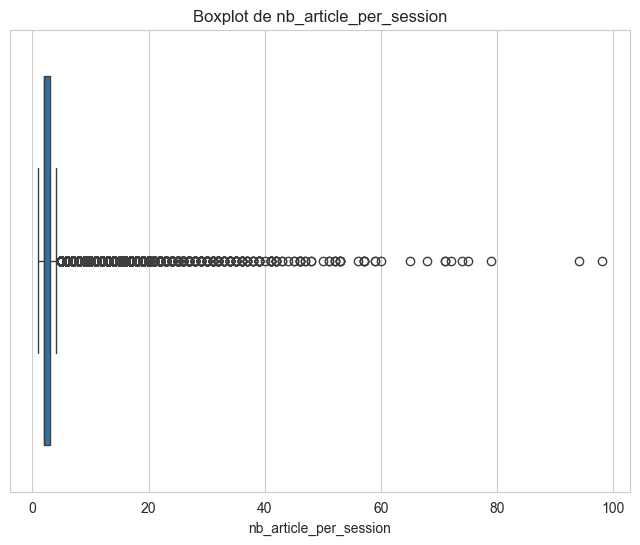

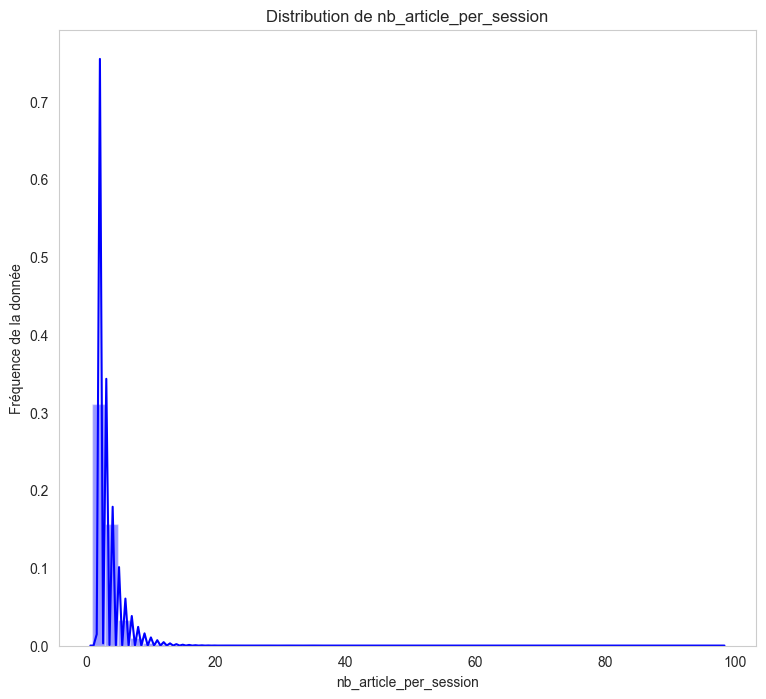

,Caractéristiques,Valeurs
0,count,1043753.000000
1,mean,2.841436
2,std,1.680384
3,min,1.000000
4,25%,2.000000
5,50%,2.000000
6,75%,3.000000
7,max,98.000000


In [45]:
describe_data_quant(session_features, 'nb_article_per_session')

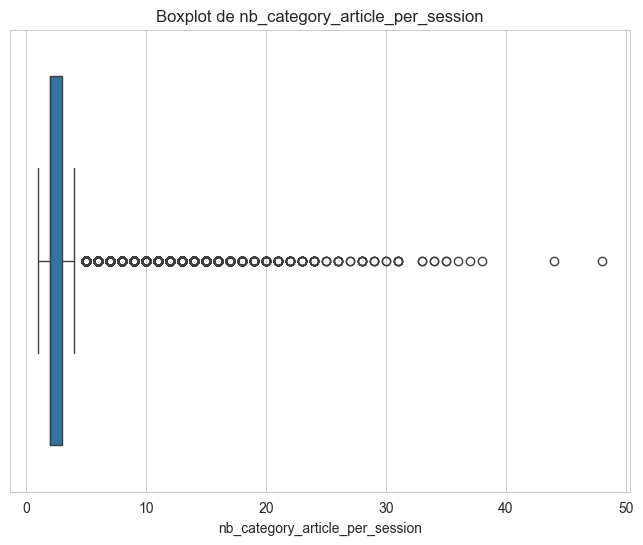

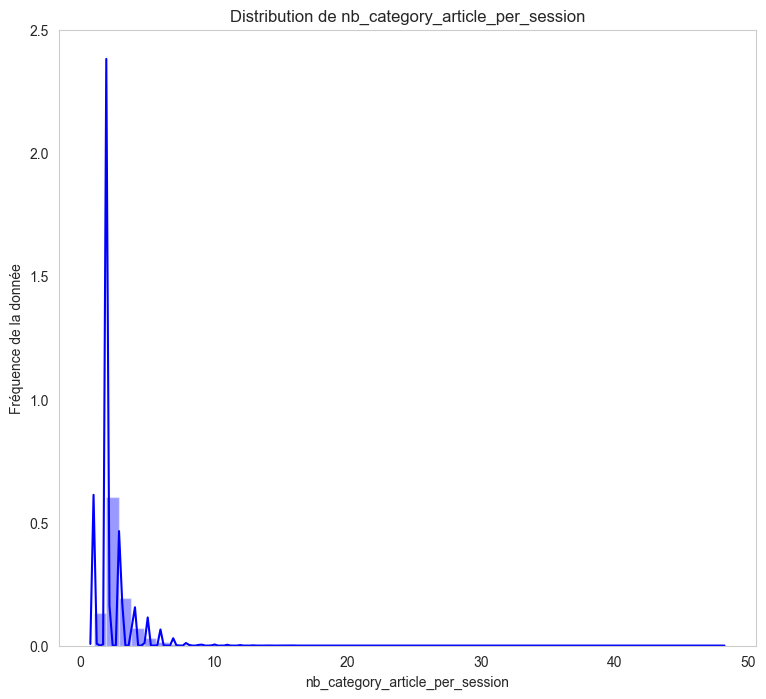

,Caractéristiques,Valeurs
0,count,1043753.000000
1,mean,2.438862
2,std,1.279685
3,min,1.000000
4,25%,2.000000
5,50%,2.000000
6,75%,3.000000
7,max,48.000000


In [46]:
describe_data_quant(session_features, 'nb_category_article_per_session')

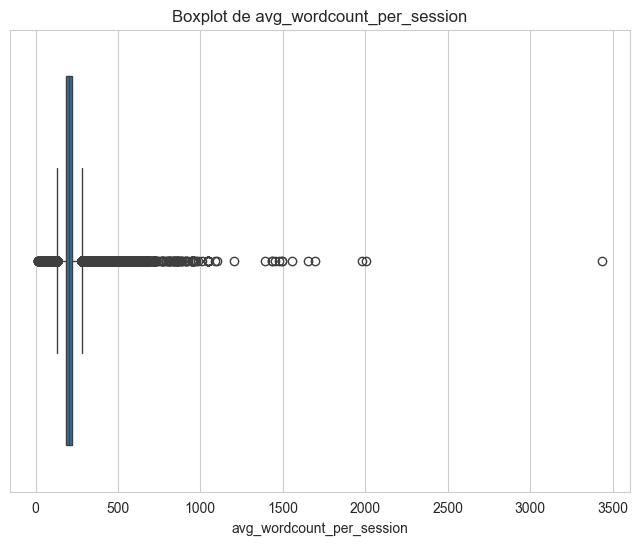

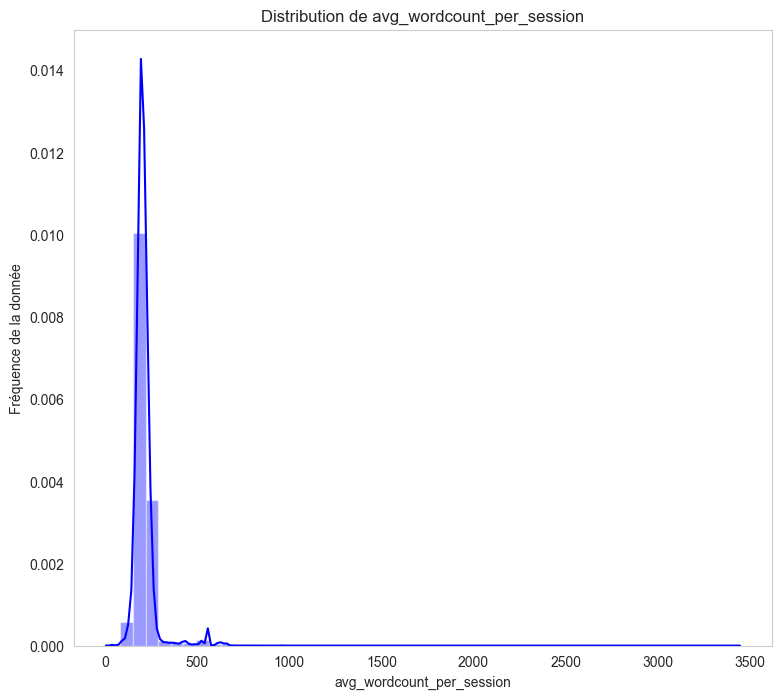

,Caractéristiques,Valeurs
0,count,1043753.000000
1,mean,210.005632
2,std,57.106829
3,min,16.000000
4,25%,185.000000
5,50%,203.000000
6,75%,223.250000
7,max,3434.500000


In [47]:
describe_data_quant(session_features, 'avg_wordcount_per_session')

In [48]:
# Jointure pour créer le dataframe post feature engineering
df_temp = dfinal.merge(user_features, on='user_id', how='left')
df_fe = df_temp.merge(session_features[['session_id','nb_article_per_session','nb_category_article_per_session','avg_wordcount_per_session']], on='session_id', how='left')
df_fe

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at,nb_session_per_user,nb_article_per_user,nb_category_article_per_user,avg_wordcount_per_user,nb_article_per_session,nb_category_article_per_session,avg_wordcount_per_session
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,281,280,2017-09-30 19:41:58,4,8,6,207.000000,2,2,253.000000
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,136,226,2017-10-01 00:08:02,4,8,6,207.000000,2,2,253.000000
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,375,159,2017-09-30 21:43:59,6,12,9,212.083333,2,2,182.500000
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,209,206,2017-09-30 16:13:45,6,12,9,212.083333,2,2,182.500000
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,247,239,2017-09-30 15:11:56,2,4,3,200.500000,2,2,227.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965752,34979,1508211369104327,2017-10-17 03:36:09,7,157478,2017-10-17 03:46:14.116,281,259,2017-10-16 04:01:02,7,23,17,198.391304,7,6,212.285714
2965753,10051,1508211372158328,2017-10-17 03:36:12,2,211442,2017-10-17 03:38:47.302,340,240,2017-10-16 21:02:00,18,49,21,201.285714,2,2,205.500000
2965754,10051,1508211372158328,2017-10-17 03:36:12,2,84911,2017-10-17 03:39:17.302,174,171,2017-10-16 21:00:19,18,49,21,201.285714,2,2,205.500000
2965755,123718,1508211379189330,2017-10-17 03:36:19,2,234481,2017-10-17 03:38:33.583,375,212,2017-10-16 19:19:32,6,14,3,189.142857,2,1,193.000000


In [49]:
df_fe.to_csv("C:/tutorial-env/OCR/Projet10/data/df_post_fe.csv", index=False)

Malheureusement il n'existe pas de données sur la fin de session. On ne peut donc pas calculer la durée de la session ce qui aurait été pertinent pour notre projet.

## Analyse multivariée:
### Corrélations:

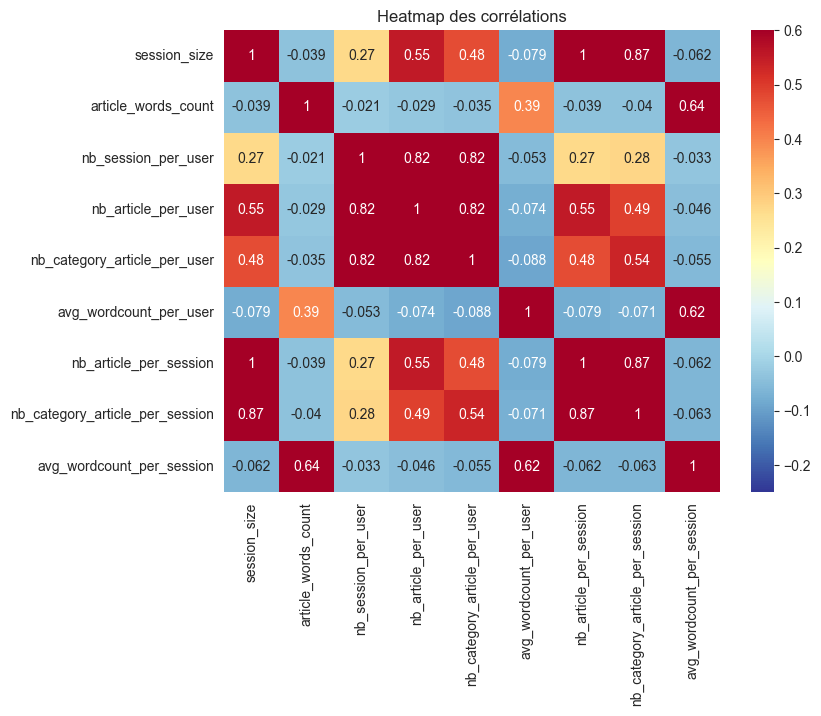

In [50]:
plt.figure(figsize = (8, 6))

# Sélection des colonnes numériques
data_corr = df_fe.select_dtypes(include=['float', 'int64', 'int32'])

# Heatmap des correlations
sns.heatmap(data_corr.corr(),
            cmap = plt.cm.RdYlBu_r,
            vmin = -0.25,
            vmax = 0.6,
            annot = True)
plt.title('Heatmap des corrélations')
plt.show()

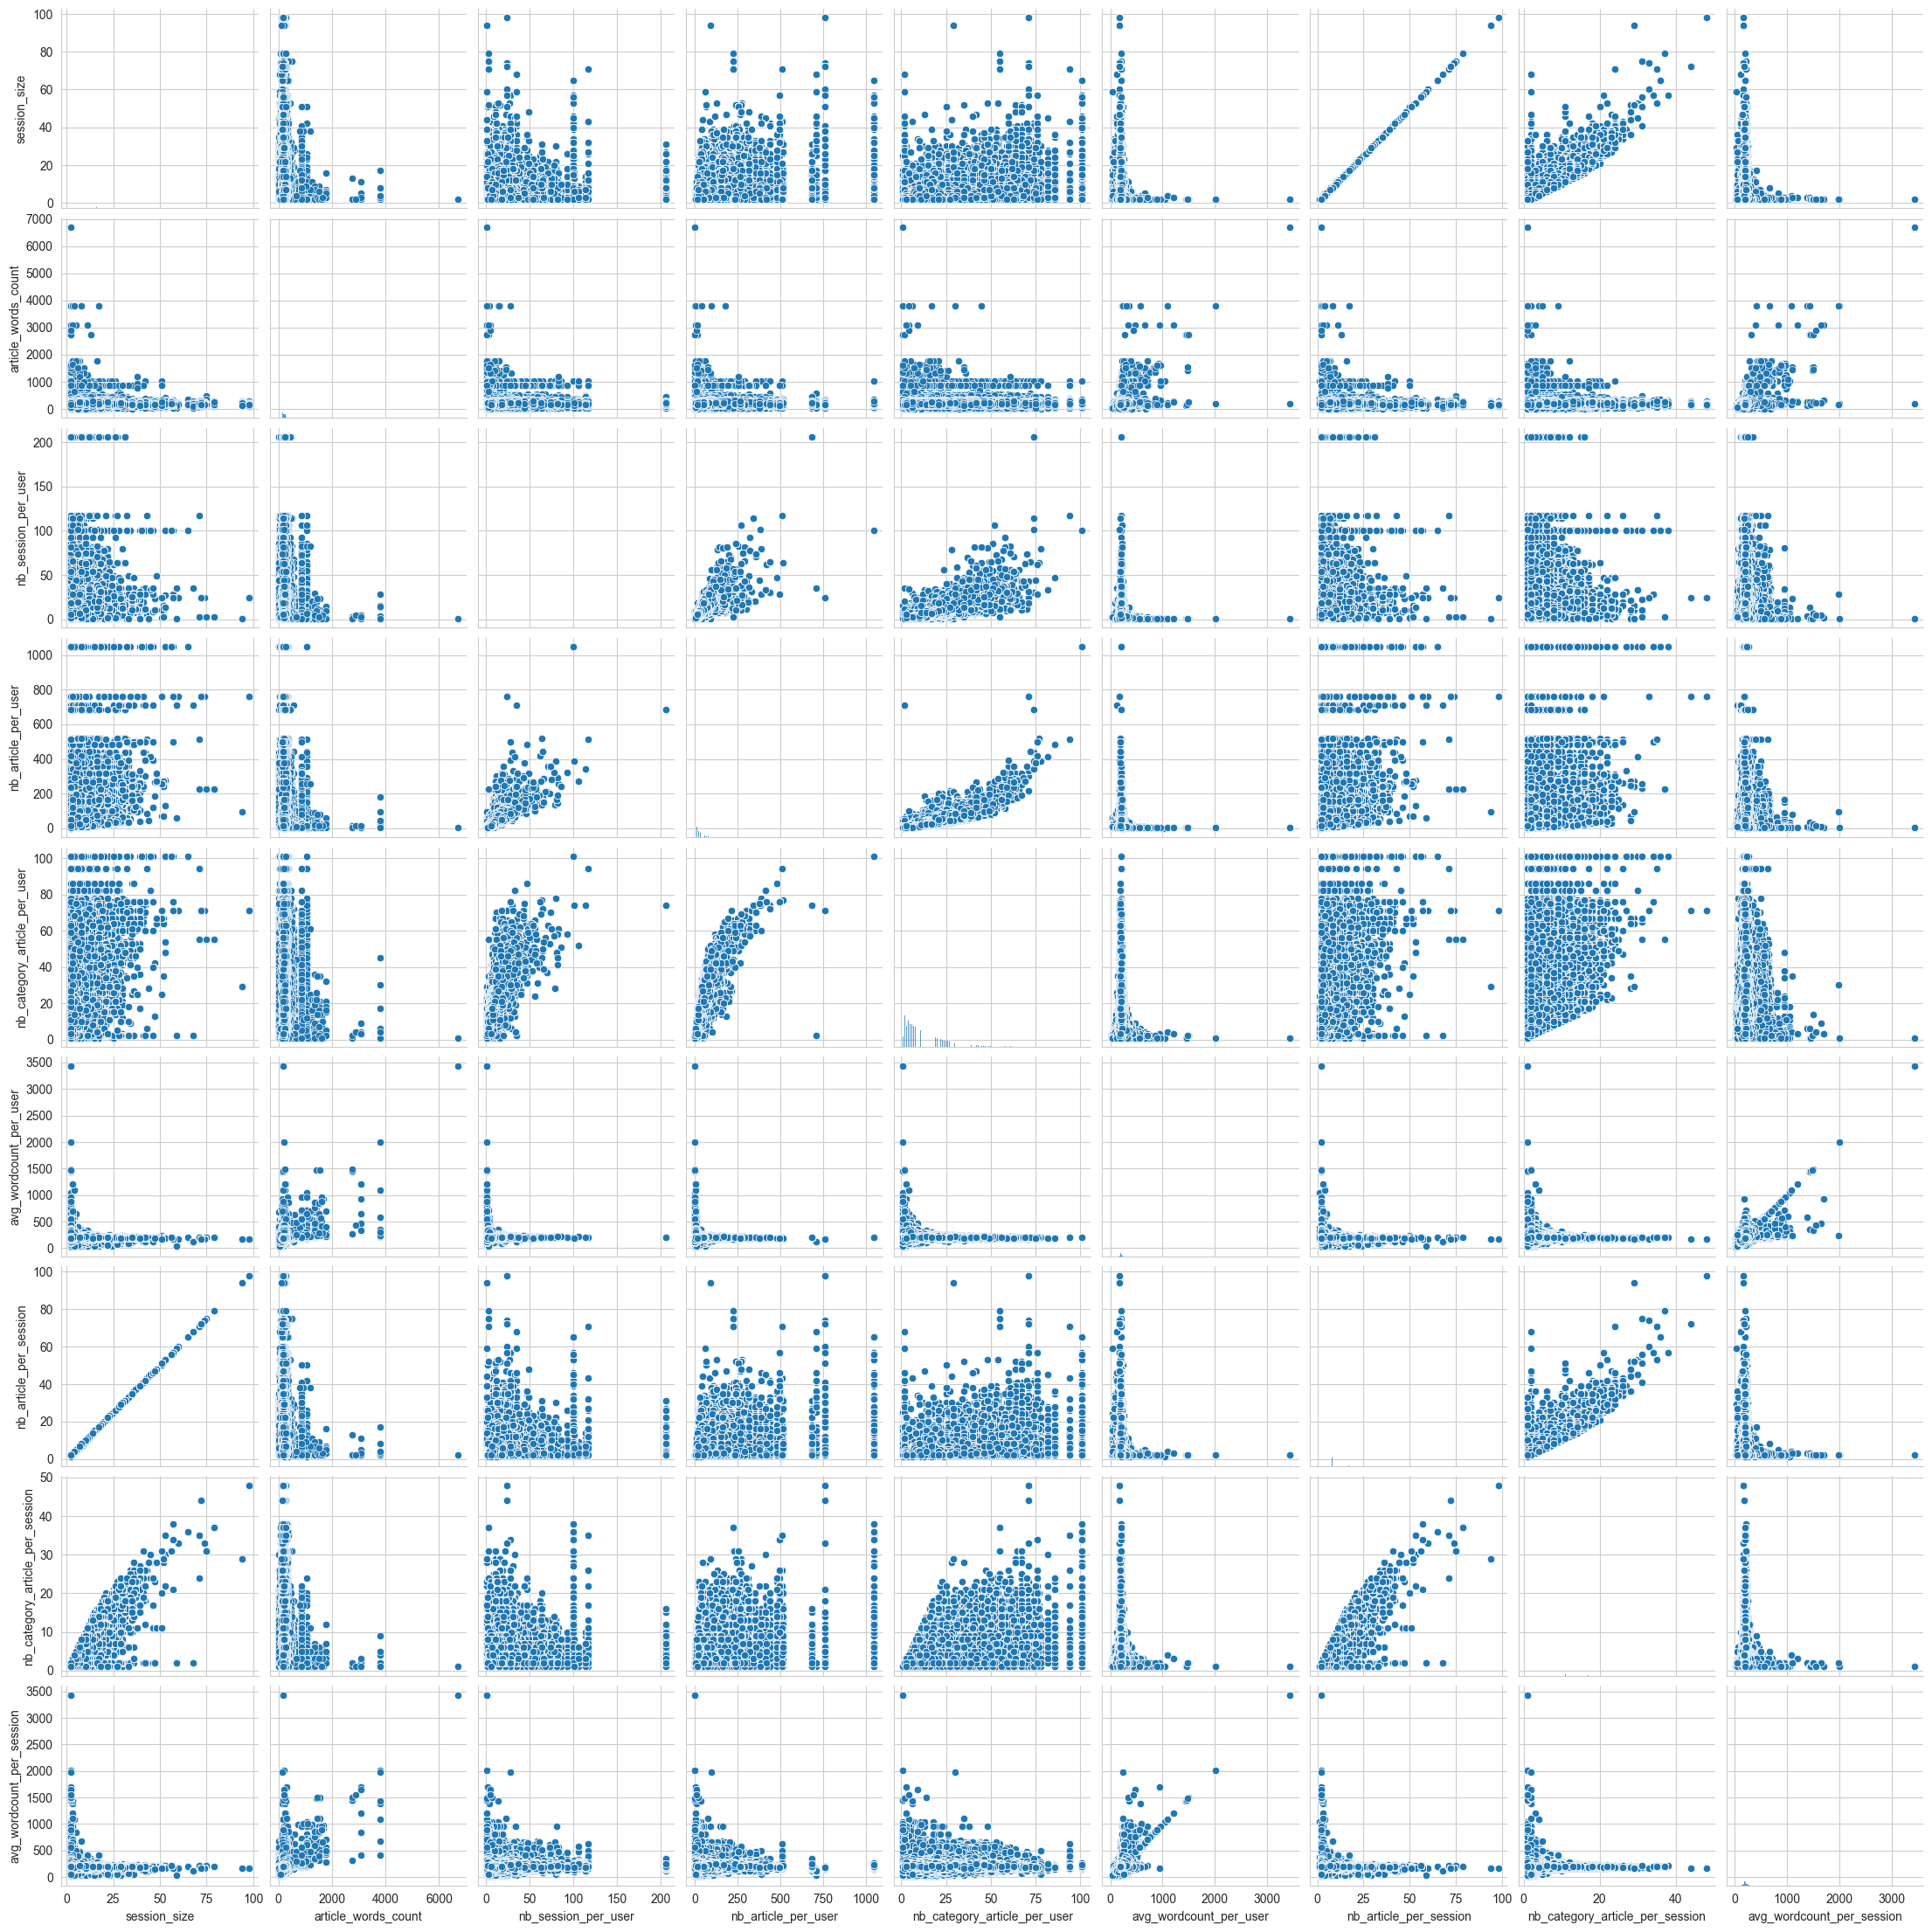

In [51]:
sns.pairplot(data_corr)
plt.show()

La colonne "session_size" est identique à la colonne "nb_article_per_session" donc chaque clic correspond à un article différent. On enlèvera la colonne "session_size".

Autrement, les plus importantes corrélations sont :    
- "nb_category_article_per_session" avec "nb_article_per_session", plus il y a d'articles de consultés dans une session, plus il y a de catégories d'articles consultés.
- "nb_category_article_per_user" avec "nb_session_per_user", plus l'utilisateur ouvre de sessions, plus il a consulté de catégories d'articles.
- "nb_category_article_per_user" avec "nb_article_per_user", plus l'utilisateur a consulté d'articles, plus il a consulté de catégories d'articles.
- "nb_article_per_user" avec "nb_session_per_user", plus l'utilisateur ouvre de sessions, plus il a consulté d'articles.

Ces corrélations semblent assez évidentes et il n'existe pas d'anti-corrélations.

### Nombre d'utilisateur selon leur nombre de sessions

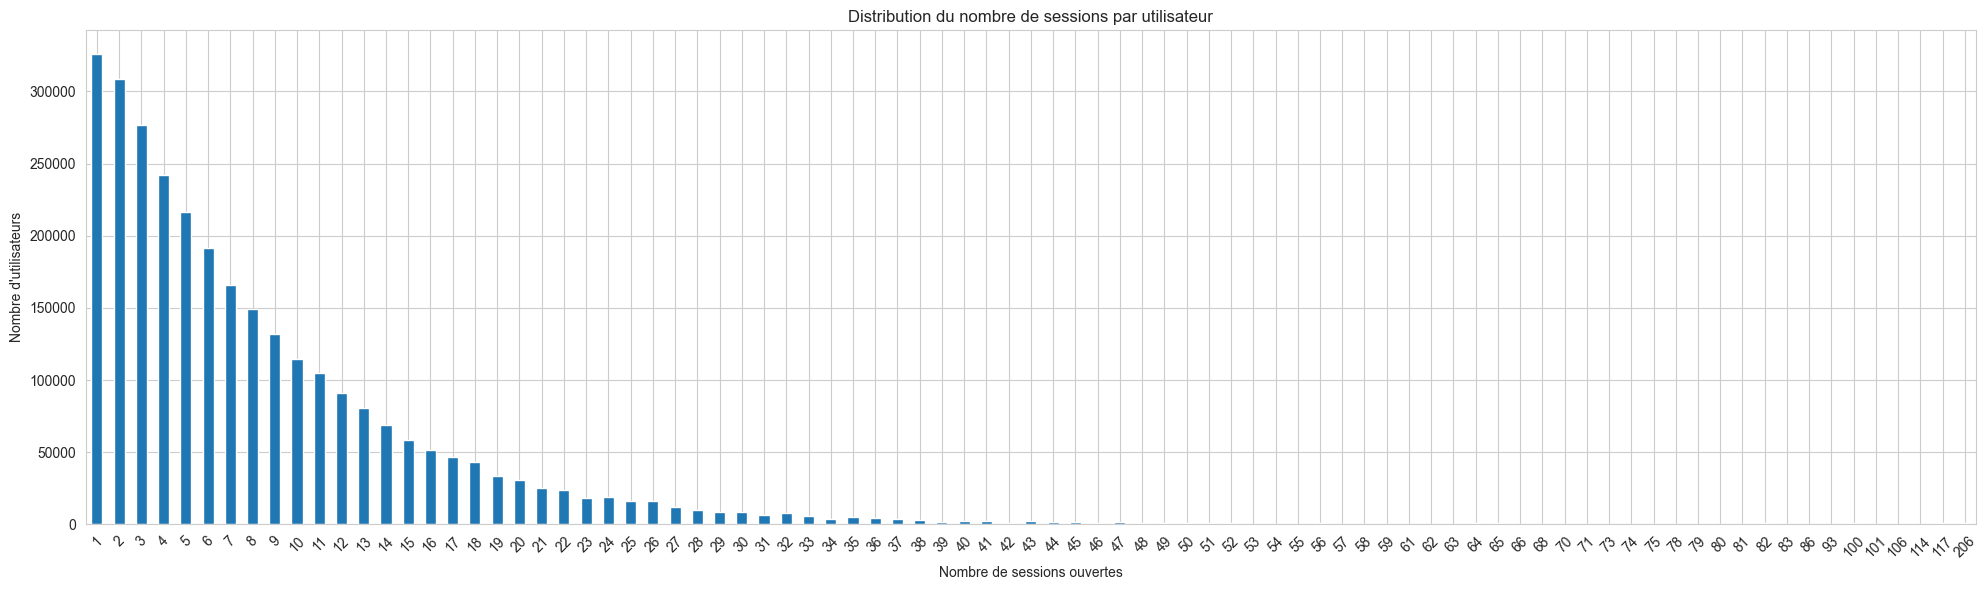

In [52]:
#  Suppression de la colonne "session_size" qui est exactement corrélé à la colonne "nb_article_per_session"
df_fe.drop(['session_size'], axis=1, inplace=True)


df = df_fe[['user_id','nb_session_per_user']]

# Nombre de sessions par utilisateur
df_plot = df['nb_session_per_user'].value_counts().sort_index()

# Visualisation
plt.figure(figsize=(20,6))
df_plot.plot(kind='bar')
plt.title("Distribution du nombre de sessions par utilisateur")
plt.xlabel("Nombre de sessions ouvertes")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Plus il y a de sessions ouvertes, moins il y a d'utilisateurs concernés.

### Nombre d'utilisateur selon leur nombre de catégories d'articles consultés

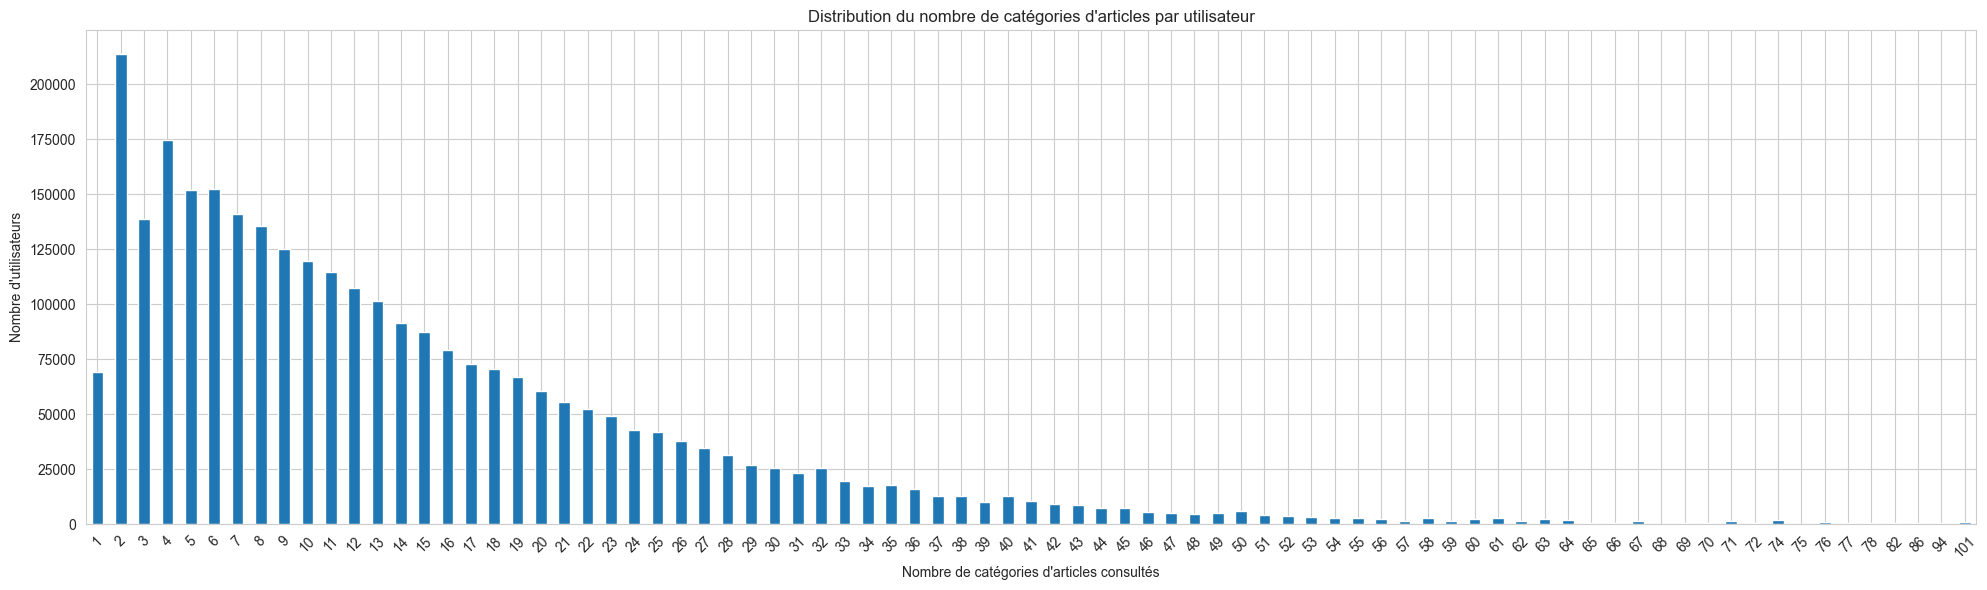

In [53]:
df = df_fe[['user_id','nb_category_article_per_user']]

# Nombre de catégories d'articles consultés par utilisateur
df_plot = df['nb_category_article_per_user'].value_counts().sort_index()

# Visualisation
plt.figure(figsize=(20,6))
df_plot.plot(kind='bar')
plt.title("Distribution du nombre de catégories d'articles par utilisateur")
plt.xlabel("Nombre de catégories d'articles consultés")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Il y a peu d'utilisateurs qui ne consultent qu'une seule catégorie d'article. Après, plus il y a de catégories d'articles consultés, moins il y a d'utilisateurs concernés.

### Nombre de sessions selon leur nombre d'articles consultés

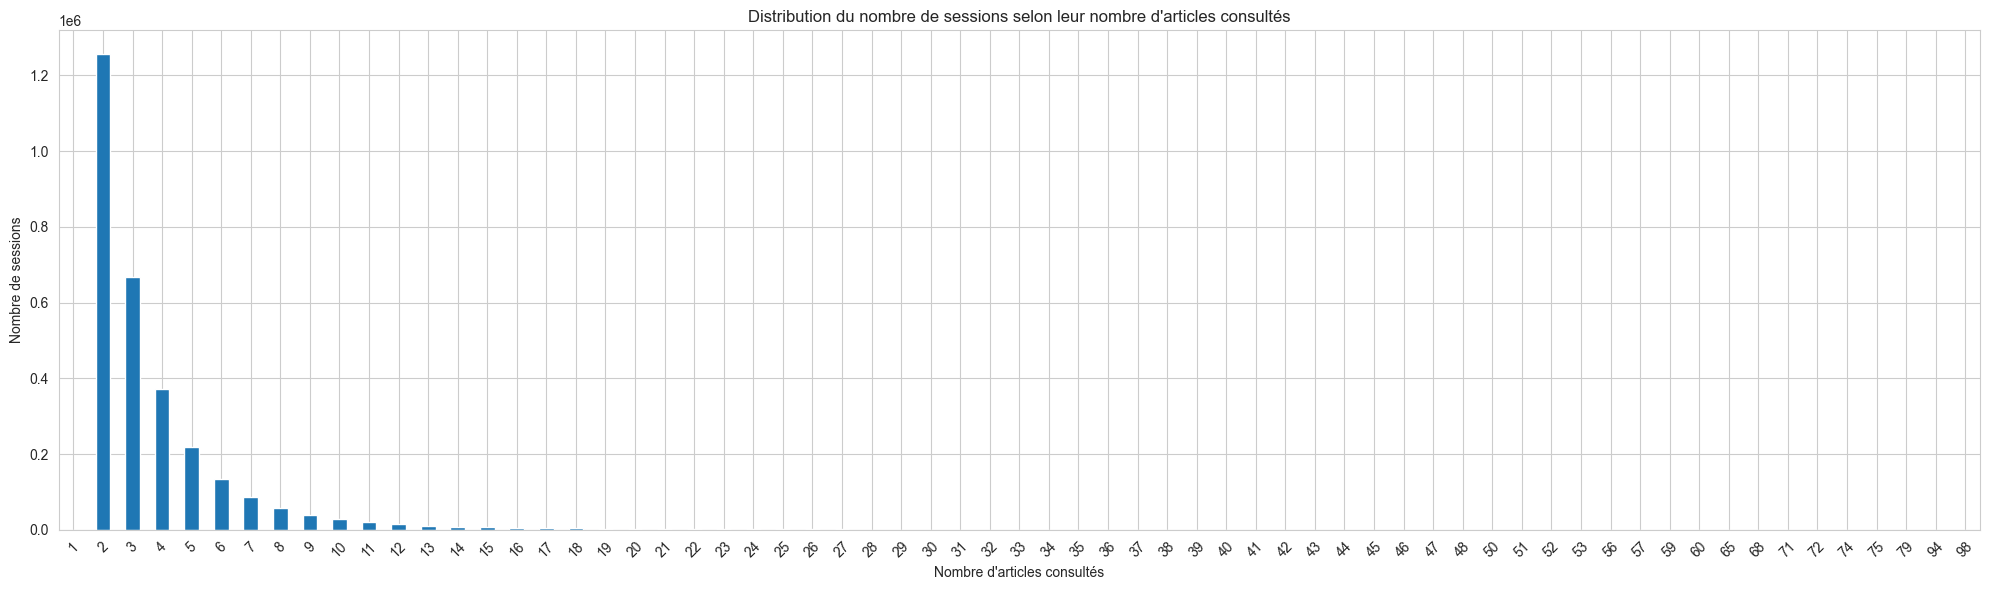

In [54]:
df = df_fe[['session_id','nb_article_per_session']]

# Nombre de sessions selon leur nombre d'articles consultés
distribution_sessions = df['nb_article_per_session'].value_counts().sort_index()

# Visualisation
plt.figure(figsize=(20,6))
distribution_sessions.plot(kind='bar')
plt.title("Distribution du nombre de sessions selon leur nombre d'articles consultés")
plt.xlabel("Nombre d'articles consultés")
plt.ylabel("Nombre de sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La grande majorité des sessions ne contiennent que 2 articles consultés. Après plus il y a d'articles consultés, mois il y a de sessions.

### Nombre de sessions selon leur nombre de catégories d'articles consultées

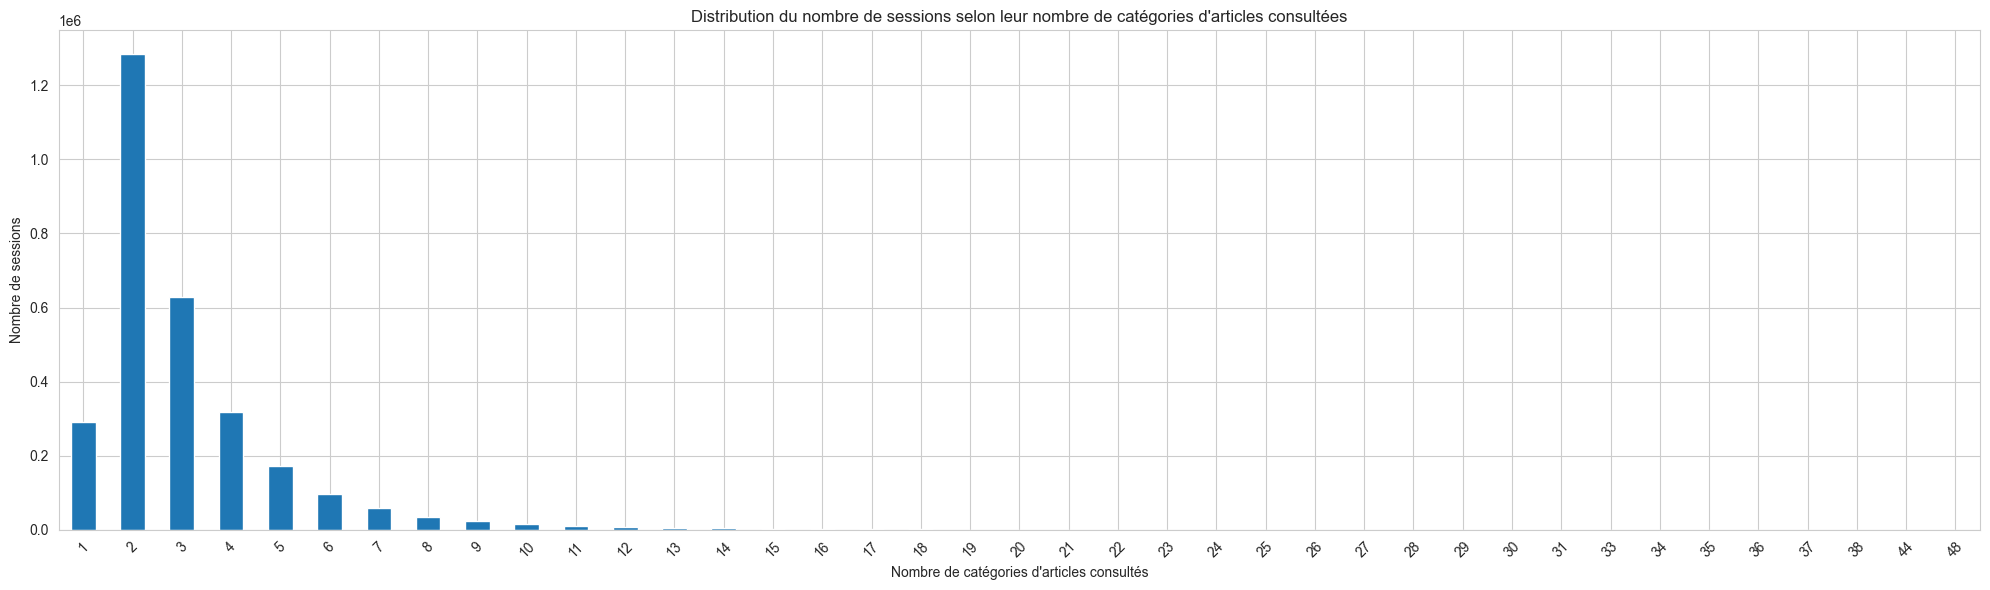

In [55]:
df = df_fe[['session_id','nb_category_article_per_session']]

# Nombre de sessions selon leur nombre d'articles consultés
distribution_sessions = df['nb_category_article_per_session'].value_counts().sort_index()

# Visualisation
plt.figure(figsize=(20,6))
distribution_sessions.plot(kind='bar')
plt.title("Distribution du nombre de sessions selon leur nombre de catégories d'articles consultées")
plt.xlabel("Nombre de catégories d'articles consultés")
plt.ylabel("Nombre de sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La grande majorité des sessions contiennent 2 catégories d'articles consultées. Peu contiennent plus de 5 catégories d'articles consultées.

## Embeddings

### PCA

On ne garde pas les identifiants pour la PCA et on transforme les timestamp en durée ou en cycle temporel :

In [5]:
with open('/content/drive/MyDrive/Colab_Notebooks/P10/articles_embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

embeddings.shape # (nb_articles, nb_dimensions)

(364047, 250)

In [9]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)

# Réduction dimensionnelle
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", X_pca.shape)

df_pca = pd.DataFrame(X_pca, index=data_articles.index)
df_pca

Dimensions dataset avant réduction PCA :  (364047, 250)
Dimensions dataset après réduction PCA :  (364047, 119)


,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,-2.176782,1.316912,-1.029048,0.901907,-1.809542,-2.064713,-1.221916,-0.024441,0.927260,-0.669806,...,0.063648,-0.062742,0.028703,0.003528,-0.104201,0.087395,-0.078140,-0.013512,-0.009239,-0.002478
1,-1.735173,-0.489893,3.268561,0.087855,1.473059,-0.932711,1.841632,-0.881799,-0.207201,0.816809,...,0.012005,-0.138427,0.094070,0.025318,-0.031953,0.101762,-0.013565,-0.167520,0.084145,-0.188992
2,-0.912688,2.089340,1.865868,-1.202519,2.530600,-0.521970,0.224352,1.479936,-0.191899,1.356800,...,0.132426,-0.066307,-0.066559,0.131542,0.087741,0.103935,-0.016733,0.058462,0.023814,0.057636
3,1.096567,-0.212955,4.183517,-0.649575,-0.130867,1.126555,1.063997,-0.662876,0.348143,1.463899,...,0.066429,-0.132980,-0.051528,-0.027700,-0.101754,-0.100752,0.018065,0.105923,0.147540,-0.032472
4,0.193785,0.263949,1.896583,-1.834345,1.270377,-1.723296,0.329006,0.283794,-0.659808,1.223740,...,0.004087,-0.084683,0.056990,-0.060152,0.015065,0.032770,-0.111261,-0.032398,0.055943,-0.118947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,1.248788,-5.252166,-0.650815,0.839686,-0.265054,0.623108,0.947454,-0.689413,-0.902329,0.525686,...,-0.056802,0.015133,0.116884,0.084226,-0.024592,0.008438,-0.103954,-0.007500,0.005592,0.031234
364043,0.575188,-2.392515,-2.702553,5.805814,2.654165,-1.924642,0.672177,-0.958555,-0.938420,0.574798,...,0.319616,0.272755,0.112621,0.039665,-0.003508,-0.033152,-0.033142,-0.041292,-0.001593,0.318893
364044,1.564129,-4.053347,2.134535,1.152970,0.980017,0.595264,-0.750342,-1.323827,0.679742,-1.937158,...,-0.103413,-0.044767,-0.039725,0.024119,-0.112703,0.092300,0.008733,0.011689,0.092814,-0.118527
364045,4.866366,-0.151831,-0.424444,-0.442650,-1.083551,0.659206,-1.366971,-0.764270,-0.182243,0.806381,...,0.086112,-0.005496,-0.046811,0.034102,0.069873,0.013200,-0.010866,-0.066666,-0.055761,0.030924


### T-SNE


In [10]:
# Prendre un échantillon
sample_size = 10000
sample_indices = np.random.choice(data_articles.index, size=sample_size, replace=False)

df_meta_sample = data_articles.loc[sample_indices]
df_pca_sample = df_pca.loc[sample_indices]

tsne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
X_tsne = tsne.fit_transform(df_pca_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.662s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.942668
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.303856
[t-SNE] KL divergence after 1000 iterations: 1.492837


In [15]:
# Transformation en Dataframe
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'], index=df_meta_sample.index)

# Fusionner
df_viz = pd.concat([df_meta_sample, df_tsne], axis=1)

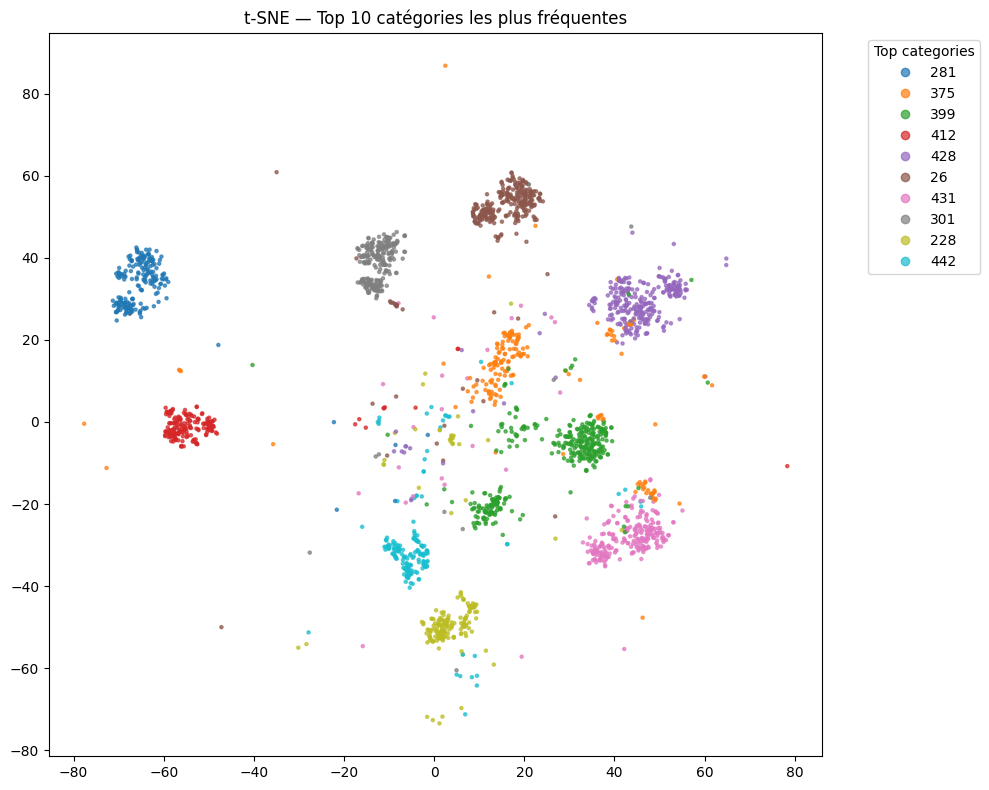

In [22]:
# Sélection des 10 catégories les plus fréquentes
top_categories = (
    df_viz['category_id']
    .value_counts()
    .head(10)
    .index
)

df_visu_top = df_viz[df_viz['category_id'].isin(top_categories)]

# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_visu_top['tsne_1'],
    df_visu_top['tsne_2'],
    c=df_visu_top['category_id'].astype('category').cat.codes,
    cmap='tab10',
    s=5,
    alpha=0.7
)

# Légende
handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, top_categories, title="Top categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE — Top 10 catégories les plus fréquentes")
plt.tight_layout()
plt.show()

Sur les 10 catégories les plus fréquentes, on voit bien des regroupements dans les embeddings, ce qui est attendu.